### Notebook Preperation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 41 kB/s 
     |████████████████████████████████| 199 kB 62.3 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=d8116598734dea0d62b4634b2a2ab6223fdb0f9df72f8055700d7f59aa1bef1d
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark


In [ ]:
enable_grid_search = True

In [ ]:
from __future__ import division
from pyspark.sql import SparkSession
from pyspark.ml import feature, regression, evaluation, Pipeline
from pyspark.sql import functions as fn, Row
from pyspark.sql.functions import mean, col, abs, when, countDistinct, isnan
from pyspark.sql import SQLContext
import matplotlib.pyplot as plt
import glob
import subprocess
import numpy as np
import pandas as pd
import os
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer, IDF, VectorAssembler
import requests

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.clustering import KMeans

from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.evaluation import BinaryClassificationEvaluator, ClusteringEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

import nltk
from nltk.corpus import stopwords
from pyspark.sql.functions import sum, avg, count
from pyspark.sql.types import IntegerType, DateType, StringType

import seaborn as sns


### Data Preperation

#### Importing the data as a spark dataframe

In [ ]:
all_seasons_df = spark.read.csv("/content/drive/MyDrive/BDA Project/nba_all_seasons.csv", inferSchema = True, header = True)
all_seasons_df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- player_name: string (nullable = true)
 |-- team_abbreviation: string (nullable = true)
 |-- age: double (nullable = true)
 |-- player_height: double (nullable = true)
 |-- player_weight: double (nullable = true)
 |-- college: string (nullable = true)
 |-- country: string (nullable = true)
 |-- draft_year: string (nullable = true)
 |-- draft_round: string (nullable = true)
 |-- draft_number: string (nullable = true)
 |-- gp: integer (nullable = true)
 |-- pts: double (nullable = true)
 |-- reb: double (nullable = true)
 |-- ast: double (nullable = true)
 |-- net_rating: double (nullable = true)
 |-- oreb_pct: double (nullable = true)
 |-- dreb_pct: double (nullable = true)
 |-- usg_pct: double (nullable = true)
 |-- ts_pct: double (nullable = true)
 |-- ast_pct: double (nullable = true)
 |-- season: string (nullable = true)



In [ ]:
print("Shape of our dataframe is: ")
print("No. of Rows: ", all_seasons_df.count())
print("No. of Columns: ", len(all_seasons_df.columns))
display(all_seasons_df.show())

Shape of our dataframe is: 
No. of Rows:  12305
No. of Columns:  22
+---+-----------------+-----------------+----+-------------+------------------+--------------------+-------+----------+-----------+------------+---+----+----+---+----------+--------------------+-------------------+-------------------+-------------------+-------------------+-------+
|_c0|      player_name|team_abbreviation| age|player_height|     player_weight|             college|country|draft_year|draft_round|draft_number| gp| pts| reb|ast|net_rating|            oreb_pct|           dreb_pct|            usg_pct|             ts_pct|            ast_pct| season|
+---+-----------------+-----------------+----+-------------+------------------+--------------------+-------+----------+-----------+------------+---+----+----+---+----------+--------------------+-------------------+-------------------+-------------------+-------------------+-------+
|  0|    Dennis Rodman|              CHI|36.0|       198.12|          99.79024|Sout

None

#### Checking for missing values

In [ ]:
all_seasons_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in all_seasons_df.columns]
   ).show()

+---+-----------+-----------------+---+-------------+-------------+-------+-------+----------+-----------+------------+---+---+---+---+----------+--------+--------+-------+------+-------+------+
|_c0|player_name|team_abbreviation|age|player_height|player_weight|college|country|draft_year|draft_round|draft_number| gp|pts|reb|ast|net_rating|oreb_pct|dreb_pct|usg_pct|ts_pct|ast_pct|season|
+---+-----------+-----------------+---+-------------+-------------+-------+-------+----------+-----------+------------+---+---+---+---+----------+--------+--------+-------+------+-------+------+
|  0|          0|                0|  0|            0|            0|      0|      0|         0|          0|           0|  0|  0|  0|  0|         0|       0|       0|      0|     0|      0|     0|
+---+-----------+-----------------+---+-------------+-------------+-------+-------+----------+-----------+------------+---+---+---+---+----------+--------+--------+-------+------+-------+------+



No values are missing in the data set

#### Fixing Schema

In [ ]:
# Converting variable "season" to date type
all_seasons_df = all_seasons_df.withColumn('season', all_seasons_df.season.substr(1,4))
all_seasons_df = all_seasons_df.withColumn("season", all_seasons_df["season"].cast(DateType()))

In [ ]:
all_seasons_df = all_seasons_df.withColumn('draft_year', when(all_seasons_df.draft_year == 'Undrafted', '0')
                                                        .otherwise(all_seasons_df.draft_year))
all_seasons_df = all_seasons_df.withColumn('draft_round', when(all_seasons_df.draft_round == 'Undrafted', '0')
                                                        .otherwise(all_seasons_df.draft_round))
all_seasons_df = all_seasons_df.withColumn('draft_number', when(all_seasons_df.draft_number == 'Undrafted', '0')
                                                        .otherwise(all_seasons_df.draft_number))

In [ ]:
# dropping column "_c0"(serial number) as it is not needed
all_seasons_df = all_seasons_df.drop('_c0')

In [ ]:
all_seasons_df = all_seasons_df.withColumn("draft_year", all_seasons_df["draft_year"].cast(IntegerType()))
all_seasons_df = all_seasons_df.withColumn("draft_round", all_seasons_df["draft_round"].cast(IntegerType()))
all_seasons_df = all_seasons_df.withColumn("draft_number", all_seasons_df["draft_number"].cast(IntegerType()))

In [ ]:
all_seasons_df.printSchema()

root
 |-- player_name: string (nullable = true)
 |-- team_abbreviation: string (nullable = true)
 |-- age: double (nullable = true)
 |-- player_height: double (nullable = true)
 |-- player_weight: double (nullable = true)
 |-- college: string (nullable = true)
 |-- country: string (nullable = true)
 |-- draft_year: integer (nullable = true)
 |-- draft_round: integer (nullable = true)
 |-- draft_number: integer (nullable = true)
 |-- gp: integer (nullable = true)
 |-- pts: double (nullable = true)
 |-- reb: double (nullable = true)
 |-- ast: double (nullable = true)
 |-- net_rating: double (nullable = true)
 |-- oreb_pct: double (nullable = true)
 |-- dreb_pct: double (nullable = true)
 |-- usg_pct: double (nullable = true)
 |-- ts_pct: double (nullable = true)
 |-- ast_pct: double (nullable = true)
 |-- season: date (nullable = true)



In [ ]:
print("New shape of our dataframe is: ")
print("No. of Rows: ", all_seasons_df.count())
print("No. of Columns: ", len(all_seasons_df.columns))
display(all_seasons_df.show())

New shape of our dataframe is: 
No. of Rows:  12305
No. of Columns:  21
+-----------------+-----------------+----+-------------+------------------+--------------------+-------+----------+-----------+------------+---+----+----+---+----------+--------------------+-------------------+-------------------+-------------------+-------------------+----------+
|      player_name|team_abbreviation| age|player_height|     player_weight|             college|country|draft_year|draft_round|draft_number| gp| pts| reb|ast|net_rating|            oreb_pct|           dreb_pct|            usg_pct|             ts_pct|            ast_pct|    season|
+-----------------+-----------------+----+-------------+------------------+--------------------+-------+----------+-----------+------------+---+----+----+---+----------+--------------------+-------------------+-------------------+-------------------+-------------------+----------+
|    Dennis Rodman|              CHI|36.0|       198.12|          99.79024|Southea

None

#### Final Summary

In [ ]:
all_seasons_df.summary().show()

+-------+--------------+-----------------+-----------------+------------------+------------------+------------+----------+------------------+------------------+-----------------+------------------+-----------------+------------------+------------------+-------------------+--------------------+-------------------+-------------------+-------------------+-------------------+
|summary|   player_name|team_abbreviation|              age|     player_height|     player_weight|     college|   country|        draft_year|       draft_round|     draft_number|                gp|              pts|               reb|               ast|         net_rating|            oreb_pct|           dreb_pct|            usg_pct|             ts_pct|            ast_pct|
+-------+--------------+-----------------+-----------------+------------------+------------------+------------+----------+------------------+------------------+-----------------+------------------+-----------------+------------------+----------------

In [ ]:
# sns.pairplot(all_seasons_df.toPandas())

### Data Exploration

#### Height and Weight Analysis

In [ ]:
physical_stats_df = all_seasons_df.groupBy("player_name") \
                                  .agg(mean("player_weight").alias("player_weight"), \
                                    mean("player_height").alias("player_height"))

physical_stats_df.show()

+----------------+------------------+------------------+
|     player_name|     player_weight|     player_height|
+----------------+------------------+------------------+
|   Reggie Miller| 86.78726933333331|200.66000000000003|
|     Terry Mills|109.76926399999999|208.28000000000003|
|  Rodney Stuckey| 92.98635999999999|195.57999999999998|
| Al-Farouq Aminu| 98.55317090909092|205.27818181818182|
|   Greg Stiemsma|         117.93392|            210.82|
|  Brandon Ingram|          86.18248|204.04666666666665|
|     Tyler Lydon|100.92421999999999|            207.01|
|  Svi Mykhailiuk| 92.98635999999999|           201.295|
|Lonnie Walker IV|         92.646166|            194.31|
|   Nassir Little|          99.79024|            195.58|
|   Eric Williams| 99.79024000000003|203.20000000000002|
|    Bobby Phills|        100.017036|            195.58|
|    Carl Herrera|          102.0582|            205.74|
|Shandon Anderson|        95.3903976|198.11999999999998|
|  Terry Cummings|109.996059999

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


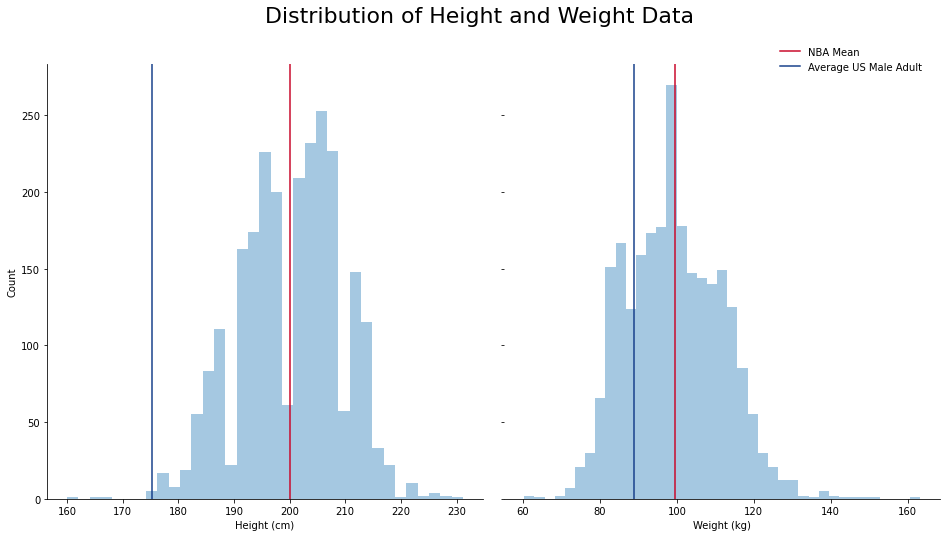

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(16, 8),sharey=True)
plt.subplots_adjust(wspace=0.05)

sns.distplot(physical_stats_df.toPandas() ['player_height'], ax=ax[0], label='_nolegend_', kde=False)
sns.distplot(physical_stats_df.toPandas() ['player_weight'], ax=ax[1], label='_nolegend_', kde=False)
ax[0].axvline(physical_stats_df.toPandas() ['player_height'].mean(), color='#c9082a', label='NBA Mean')
ax[1].axvline(physical_stats_df.toPandas() ['player_weight'].mean(), color='#c9082a', label='NBA Mean')

ax[0].axvline(175.3, color='#17408b', label='Average US Male Adult')
ax[1].axvline(88.8, color='#17408b', label='Average US Male Adult')

ax[0].yaxis.set_label_text('Count')
ax[0].xaxis.set_label_text('Height (cm)')
ax[1].xaxis.set_label_text('Weight (kg)')
plt.suptitle('Distribution of Height and Weight Data', fontsize=22)
plt.legend(loc='upper right', bbox_to_anchor=(0.98, 1.06), frameon=False)
sns.despine(ax=ax[1], left=True)
sns.despine(ax=ax[0])

plt.show()

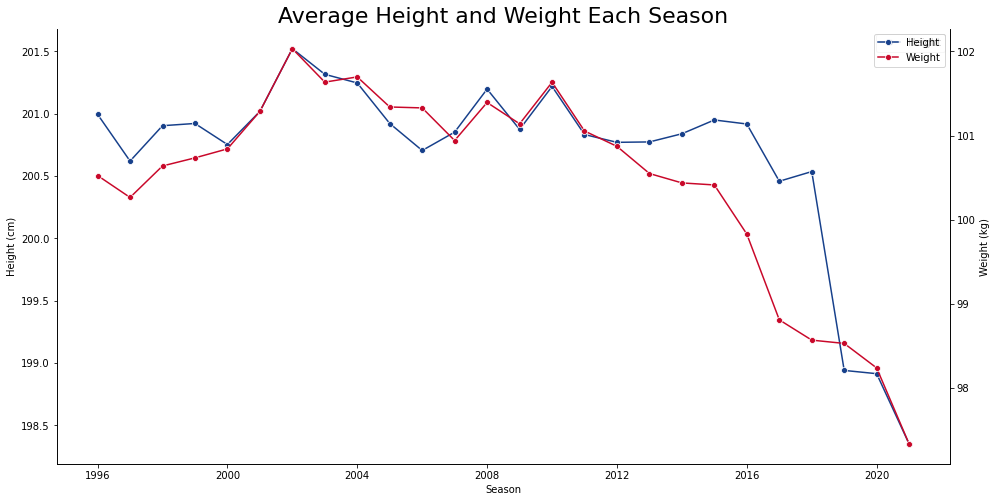

In [ ]:
fig, ax = plt.subplots(figsize=(16, 8))
ax2 = ax.twinx()

sns.lineplot(x=all_seasons_df.toPandas()['season'], y='player_height', data=all_seasons_df.toPandas(), marker="o", ax=ax, ci=None, label='Height', color='#17408b')
sns.lineplot(x=all_seasons_df.toPandas()['season'], y='player_weight', data=all_seasons_df.toPandas(), marker="o", ax=ax2, ci=None, label='Weight', color='#c9082a')

plt.title('Average Height and Weight Each Season', fontsize=22)
ax.xaxis.set_label_text('Season')
ax.yaxis.set_label_text('Height (cm)')
ax2.yaxis.set_label_text('Weight (kg)')

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

ax.spines['top'].set_visible(False)
ax2.spines['top'].set_visible(False)

plt.show()

#### Height and Weight based on Draft Year

In [ ]:
updated_df = all_seasons_df.filter(all_seasons_df.draft_year > 0)

updated_df = updated_df.withColumn("draft_year", updated_df["draft_year"].cast(StringType()))
updated_df = updated_df.withColumn("draft_year", updated_df["draft_year"].cast(DateType()))

updated_df = updated_df.filter(updated_df.season == updated_df.draft_year)

In [ ]:
hw_stats_draft_year = updated_df.groupBy("player_name") \
                                  .agg(mean("player_weight").alias("player_weight"), \
                                    mean("player_height").alias("player_height"))

hw_stats_draft_year.show()

+--------------------+------------------+-------------+
|         player_name|     player_weight|player_height|
+--------------------+------------------+-------------+
|      Rodney Stuckey| 92.98635999999999|       195.58|
|     Al-Farouq Aminu| 97.52228000000001|       205.74|
|      Brandon Ingram|          86.18248|       205.74|
|         Tyler Lydon|          99.79024|       205.74|
|      Svi Mykhailiuk| 92.98635999999999|        203.2|
|    Lonnie Walker IV| 92.98635999999999|       195.58|
|       Nassir Little|          99.79024|       195.58|
|    Shandon Anderson| 94.34713599999999|       198.12|
|        Andre Miller|         92.079176|       187.96|
|      Marcus Haislip|         104.32616|       208.28|
|      Viktor Khryapa|          95.25432|       205.74|
|      Kevin Seraphin|          124.7378|       205.74|
|         Zach LaVine|         83.007336|       195.58|
|    Jarrell Brantley|           113.398|       195.58|
|      Korleone Young|         96.615096|       

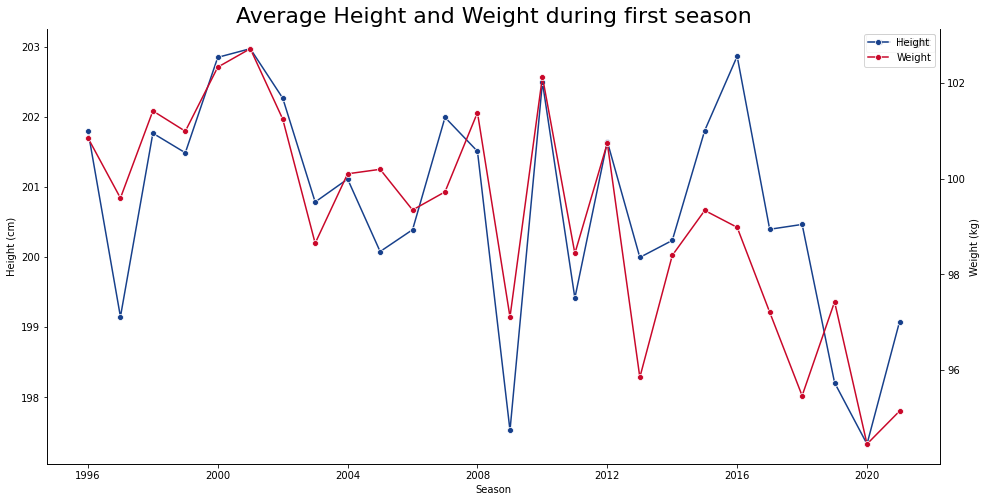

In [ ]:
fig, ax = plt.subplots(figsize=(16, 8))
ax2 = ax.twinx()

sns.lineplot(x=updated_df.toPandas()['season'], y='player_height', data=updated_df.toPandas(), marker="o", ax=ax, ci=None, label='Height', color='#17408b')
sns.lineplot(x=updated_df.toPandas()['season'], y='player_weight', data=updated_df.toPandas(), marker="o", ax=ax2, ci=None, label='Weight', color='#c9082a')

plt.title('Average Height and Weight during first season', fontsize=22)
ax.xaxis.set_label_text('Season')
ax.yaxis.set_label_text('Height (cm)')
ax2.yaxis.set_label_text('Weight (kg)')

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

ax.spines['top'].set_visible(False)
ax2.spines['top'].set_visible(False)

plt.show()

### Modelling

#### Prediction if player is offensive

In [ ]:
threshold= 0.51

def offensive_player(ts_pct):
    if ts_pct >= threshold:
      return '1'
    else:
      return '0'

off = fn.udf(lambda ts_pct: offensive_player(ts_pct))
offensive_player_df = all_seasons_df.withColumn('offensive', off(fn.col('ts_pct')))

In [ ]:
display(offensive_player_df.show())

+-----------------+-----------------+----+-------------+------------------+--------------------+-------+----------+-----------+------------+---+----+----+---+----------+--------------------+-------------------+-------------------+-------------------+-------------------+----------+---------+
|      player_name|team_abbreviation| age|player_height|     player_weight|             college|country|draft_year|draft_round|draft_number| gp| pts| reb|ast|net_rating|            oreb_pct|           dreb_pct|            usg_pct|             ts_pct|            ast_pct|    season|offensive|
+-----------------+-----------------+----+-------------+------------------+--------------------+-------+----------+-----------+------------+---+----+----+---+----------+--------------------+-------------------+-------------------+-------------------+-------------------+----------+---------+
|    Dennis Rodman|              CHI|36.0|       198.12|          99.79024|Southeastern Okla...|    USA|      1986|         

None

In [ ]:
offensive_player_df = offensive_player_df.withColumn("offensive", offensive_player_df["offensive"].cast(IntegerType()))

In [ ]:
train, validation, test = offensive_player_df.randomSplit([0.7, 0.2, 0.1])

In [ ]:
# your code here
va = VectorAssembler(inputCols= ['oreb_pct','ast_pct','pts','ast'], outputCol= 'offense_features')
lr = LogisticRegression(featuresCol= 'offense_features', labelCol= 'offensive')
lr_pipe = Pipeline(stages= [va, lr])

if enable_grid_search:
  grid = paramGrid = ParamGridBuilder().\
      addGrid(lr.elasticNetParam, [0., 0.01, 0.1]).\
      addGrid(lr.regParam, [0.1, 0.01, 0.001]).\
      build()

  all_models = []
  for j in range(len(grid)):
      print("Fitting model {}".format(j+1))
      model = lr_pipe.fit(train, grid[j])
      all_models.append(model)

  
  crossval = CrossValidator(estimator= lr_pipe, 
                          estimatorParamMaps= paramGrid, 
                          evaluator= BinaryClassificationEvaluator(), 
                          numFolds= 3)
    
  accuracies = [m.\
      transform(validation).\
      select(fn.avg(fn.expr('float(offensive = prediction)')).alias('accuracy')).\
      first().\
      accuracy for m in all_models]
  accuracies
  best_model_idx = np.argmax(accuracies)
  print("best model index =", best_model_idx)
  best_model = all_models[best_model_idx]
  print("best model accuracy =", accuracies[best_model_idx])
  display(grid[best_model_idx])

pass

Fitting model 1
Fitting model 2
Fitting model 3
Fitting model 4
Fitting model 5
Fitting model 6
Fitting model 7
Fitting model 8
Fitting model 9
best model index = 7
best model accuracy = 0.721976697468863


{Param(parent='LogisticRegression_4ef8e8f33869', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.1,
 Param(parent='LogisticRegression_4ef8e8f33869', name='regParam', doc='regularization parameter (>= 0).'): 0.01}

In [ ]:
alpha_par = 0.1
lambda_par = 0.001

en_lr = LogisticRegression().\
        setLabelCol('offensive').\
        setFeaturesCol('offense_features').\
        setRegParam(lambda_par).\
        setMaxIter(100).\
        setElasticNetParam(alpha_par)

lr_pipe = Pipeline(stages=[va,en_lr]).fit(train)
best_offensive_player_df = lr_pipe.transform(test)

eval_auc = BinaryClassificationEvaluator(labelCol='offensive', rawPredictionCol= 'prediction', metricName= 'areaUnderROC')
AUC_best = eval_auc.evaluate(best_offensive_player_df)
print("AUC for optimized model is : ", AUC_best)

AUC for optimized model is :  0.7197020421827921


#### Clustering

In [ ]:
clustering_df = all_seasons_df.select('player_height', 'player_weight', 'pts', 'reb', 'ast', 'net_rating')
clustering_df.show()

+-------------+------------------+----+----+---+----------+
|player_height|     player_weight| pts| reb|ast|net_rating|
+-------------+------------------+----+----+---+----------+
|       198.12|          99.79024| 5.7|16.1|3.1|      16.1|
|        215.9|         117.93392| 2.3| 1.5|0.3|      12.3|
|       205.74|          95.25432| 0.8| 1.0|0.4|      -2.1|
|        203.2|        100.697424| 3.7| 2.3|0.6|      -8.7|
|       205.74|         108.86208| 2.4| 2.4|0.2|     -11.2|
|       200.66| 97.52228000000001| 8.2| 2.7|1.0|       4.1|
|       198.12|          86.18248|17.2| 4.1|3.4|       4.1|
|       213.36|           113.398|14.9| 8.0|1.6|       3.3|
|       193.04|          86.18248| 5.7| 1.6|1.3|      -0.3|
|       182.88|          72.57472| 6.9| 1.5|3.0|      -1.2|
|       182.88|          77.11064| 2.4| 0.4|1.2|      -7.4|
|       213.36|122.46983999999999| 0.0| 0.0|0.0|    -147.5|
|       195.58|         87.996848| 5.0| 1.7|2.0|       6.6|
|        190.5| 80.28578399999998| 1.3| 

In [ ]:
assembler = feature.VectorAssembler(inputCols=['player_height', 'player_weight', 'pts', 'reb', 'ast', 'net_rating'], outputCol='features')

In [ ]:
center = feature.StandardScaler(withMean=True, withStd=False, inputCol='features', outputCol='centered_features')

In [ ]:
silhouette_score=[]
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='centered_features', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')
for i in range(2,10):   
    KMeans_algo=KMeans(featuresCol='centered_features', k=i)

    cluster_pipe = Pipeline(stages = [assembler,
                                      center,
                                      KMeans_algo        
                                        ])
    
    KMeans_fit=cluster_pipe.fit(clustering_df)
    output=KMeans_fit.transform(clustering_df)
        
    score=evaluator.evaluate(output)    
    silhouette_score.append(score)
    print("Silhouette Score:",score)

Silhouette Score: 0.4967151351934525
Silhouette Score: 0.5290374182581622
Silhouette Score: 0.38343975606109604
Silhouette Score: 0.3701815144315625
Silhouette Score: 0.39756617241867864
Silhouette Score: 0.283157984667062
Silhouette Score: 0.37643957617023865
Silhouette Score: 0.31689813192936217


Text(0, 0.5, 'cost')

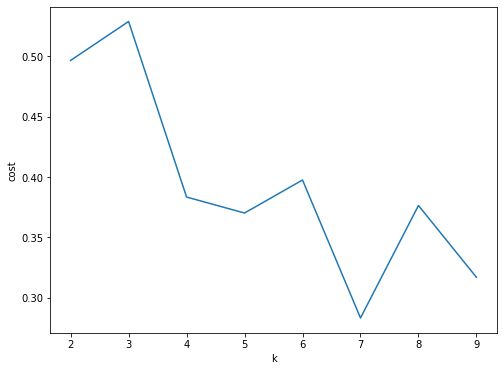

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,10),silhouette_score)
ax.set_xlabel('k')
ax.set_ylabel('cost')

Local maxima appears to occur at k = 5, so, performing clustering with k = 5

In [ ]:
#Final clustering Model
kmeans_5 = KMeans(featuresCol='centered_features', k=5)
cluster_pipe_5 = Pipeline(stages = [assembler, center, kmeans_5])

KMeans_5_fit = cluster_pipe_5.fit(clustering_df)
clustering_output = KMeans_5_fit.transform(clustering_df)

clustering_output.show()

+-------------+------------------+----+----+---+----------+--------------------+--------------------+----------+
|player_height|     player_weight| pts| reb|ast|net_rating|            features|   centered_features|prediction|
+-------------+------------------+----+----+---+----------+--------------------+--------------------+----------+
|       198.12|          99.79024| 5.7|16.1|3.1|      16.1|[198.12,99.79024,...|[-2.4916017878906...|         3|
|        215.9|         117.93392| 2.3| 1.5|0.3|      12.3|[215.9,117.93392,...|[15.2883982121093...|         0|
|       205.74|          95.25432| 0.8| 1.0|0.4|      -2.1|[205.74,95.25432,...|[5.12839821210931...|         1|
|        203.2|        100.697424| 3.7| 2.3|0.6|      -8.7|[203.2,100.697424...|[2.58839821210929...|         1|
|       205.74|         108.86208| 2.4| 2.4|0.2|     -11.2|[205.74,108.86208...|[5.12839821210931...|         1|
|       200.66| 97.52228000000001| 8.2| 2.7|1.0|       4.1|[200.66,97.522280...|[0.0483982121093

#### Random Forest Regressor for Net Rating

In [ ]:
rating_df = all_seasons_df.filter(all_seasons_df.season == "2018-01-01").select('team_abbreviation', 'age', 'player_height', 'player_weight', 'gp', 'pts', 'reb', 'ast', 'net_rating', 'oreb_pct', 'dreb_pct', 'usg_pct', 'ts_pct', 'ast_pct')

print("Shape of our dataframe is: ")
print("No. of Rows: ", rating_df.count())
print("No. of Columns: ", len(rating_df.columns))
display(rating_df.show())

Shape of our dataframe is: 
No. of Rows:  530
No. of Columns:  14
+-----------------+----+-------------+------------------+---+----+---+---+----------+--------------------+-------------------+-------------------+------------------+--------------------+
|team_abbreviation| age|player_height|     player_weight| gp| pts|reb|ast|net_rating|            oreb_pct|           dreb_pct|            usg_pct|            ts_pct|             ast_pct|
+-----------------+----+-------------+------------------+---+----+---+---+----------+--------------------+-------------------+-------------------+------------------+--------------------+
|              IND|22.0|       208.28|          102.0582| 58| 3.9|2.2|0.4|       3.6|               0.077|              0.145|              0.158|0.5720000000000001|               0.063|
|              HOU|27.0|       205.74|114.30518400000001|  2| 1.0|2.0|0.0|     -95.6|                 0.0| 0.5710000000000001|0.33299999999999996|             0.225|                 0.0|

None

In [ ]:
rating_df.printSchema()

root
 |-- team_abbreviation: string (nullable = true)
 |-- age: double (nullable = true)
 |-- player_height: double (nullable = true)
 |-- player_weight: double (nullable = true)
 |-- gp: integer (nullable = true)
 |-- pts: double (nullable = true)
 |-- reb: double (nullable = true)
 |-- ast: double (nullable = true)
 |-- net_rating: double (nullable = true)
 |-- oreb_pct: double (nullable = true)
 |-- dreb_pct: double (nullable = true)
 |-- usg_pct: double (nullable = true)
 |-- ts_pct: double (nullable = true)
 |-- ast_pct: double (nullable = true)



In [ ]:
all_seasons_df.toPandas()["team_abbreviation"].unique()

array(['CHI', 'LAC', 'TOR', 'DAL', 'MIA', 'HOU', 'LAL', 'ATL', 'MIL',
       'DEN', 'SEA', 'POR', 'VAN', 'NJN', 'BOS', 'IND', 'SAC', 'MIN',
       'PHI', 'ORL', 'SAS', 'PHX', 'DET', 'CHH', 'CLE', 'GSW', 'UTA',
       'WAS', 'NYK', 'MEM', 'NOH', 'CHA', 'NOK', 'OKC', 'BKN', 'NOP'],
      dtype=object)

In [ ]:
train_df, validate_df, test_df = rating_df.randomSplit([0.7,0.2,0.1])

In [ ]:
#pipeline to encode category variable "team_abbreviation"
team_pipe =Pipeline(stages = [feature.StringIndexer(inputCol='team_abbreviation', outputCol='indexed_team')])
va = VectorAssembler(inputCols= ['indexed_team', 'age', 'player_height', 'player_weight', 'gp', 'pts', 'reb', 'ast', 'oreb_pct', 'dreb_pct', 'usg_pct', 'ts_pct', 'ast_pct'], outputCol='features')
std = feature.StandardScaler(withMean=True, withStd=False, inputCol='features', outputCol='centered_features')

In [ ]:
rf_rating = RandomForestRegressor(labelCol = 'net_rating', featuresCol='centered_features', numTrees=20, maxDepth=5,maxBins=20)
rf_rating_pipe = Pipeline(stages=[team_pipe, va, std, rf_rating])

# draft_round_df = best_rf_pipe.transform(test_df)

In [ ]:
rf_rating_model = rf_rating_pipe.fit(train_df)

In [ ]:
results_df = rf_rating_model.transform(test_df)
results_df.show()

+-----------------+----+-------------+------------------+---+----+---+---+----------+--------------------+-------------------+-------------------+-------------------+-------------------+------------+--------------------+--------------------+-------------------+
|team_abbreviation| age|player_height|     player_weight| gp| pts|reb|ast|net_rating|            oreb_pct|           dreb_pct|            usg_pct|             ts_pct|            ast_pct|indexed_team|            features|   centered_features|         prediction|
+-----------------+----+-------------+------------------+---+----+---+---+----------+--------------------+-------------------+-------------------+-------------------+-------------------+------------+--------------------+--------------------+-------------------+
|              ATL|20.0|       200.66|          86.18248| 75| 9.7|3.3|2.9|      -2.2|0.027000000000000003|              0.087|              0.153| 0.5329999999999999|              0.139|        22.0|[22.0,20.0,200.

In [ ]:
evaluator = evaluation.RegressionEvaluator()
evaluator.setPredictionCol("prediction")

print("mean square error from built in function:")
evaluator.evaluate(results_df.select(fn.col("net_rating"),fn.col("prediction")), {evaluator.labelCol: "net_rating", evaluator.metricName: "mse"})

mean square error from built in function:


224.81901414879718

Draft-Round Prediction

In [ ]:
all_season = all_seasons_df[all_seasons_df['draft_number'] != 0]
draft_pred = all_season.select('draft_round', 'pts', 'player_height','player_weight','reb','gp')
draft_pred = draft_pred[draft_pred['draft_round'] <= 2]

In [ ]:
train_df, validate_df, test_df = draft_pred.randomSplit([0.7,0.2,0.1])

In [ ]:
va_assembler = VectorAssembler(inputCols= ['pts', 'player_height','player_weight','reb','gp'], outputCol='round')
std = feature.StandardScaler(withMean=True, withStd=False, inputCol='round', outputCol='centered_round')

In [ ]:
lr_draft = LogisticRegression(labelCol = 'draft_round', featuresCol='centered_round')
lr_draft_pipeline = Pipeline(stages=[va_assembler, std, lr_draft])

if enable_grid_search:
  grid = paramGrid = ParamGridBuilder().\
      addGrid(lr_draft.elasticNetParam, [0., 0.01, 0.1]).\
      addGrid(lr_draft.regParam, [0.1, 0.01, 0.001]).\
      build()

  all_models = []
  for j in range(len(grid)):
      print("Fitting model {}".format(j+1))
      model = lr_draft_pipeline.fit(train_df, grid[j])
      all_models.append(model)
  
  crossval = CrossValidator(estimator= lr_draft_pipeline, 
                          estimatorParamMaps= paramGrid, 
                          evaluator= BinaryClassificationEvaluator(), 
                          numFolds= 3)   
  accuracies = [m.\
      transform(validate_df).\
      select(fn.avg(fn.expr('float(draft_round = prediction)')).alias('accuracy')).\
      first().\
      accuracy for m in all_models]
  accuracies
  best_model_idx = np.argmax(accuracies)
  print("best model index =", best_model_idx)
  best_model = all_models[best_model_idx]
  print("best model accuracy =", accuracies[best_model_idx])
  display(grid[best_model_idx])
pass

Fitting model 1
Fitting model 2
Fitting model 3
Fitting model 4
Fitting model 5
Fitting model 6
Fitting model 7
Fitting model 8
Fitting model 9
best model index = 8
best model accuracy = 0.6995537927615271


{Param(parent='LogisticRegression_8d0b73032031', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.1,
 Param(parent='LogisticRegression_8d0b73032031', name='regParam', doc='regularization parameter (>= 0).'): 0.001}

In [ ]:
alpha_par1 = 0.1
lambda_par1 = 0.001

draft_lr = LogisticRegression().\
        setLabelCol('draft_round').\
        setFeaturesCol('centered_round').\
        setRegParam(lambda_par1).\
        setMaxIter(100).\
        setElasticNetParam(alpha_par1)

draft_best = Pipeline(stages=[va_assembler, std, draft_lr]).fit(train_df)
best_draft_df = draft_best.transform(test_df)

In [ ]:
best_draft_df.select(fn.avg(fn.expr('float(draft_round = prediction)')).alias('accuracy')).show()

+------------------+
|          accuracy|
+------------------+
|0.7313725490196078|
+------------------+



In [ ]:
best_draft_df.select('draft_round','prediction').show(30)

+-----------+----------+
|draft_round|prediction|
+-----------+----------+
|          1|       2.0|
|          1|       2.0|
|          1|       2.0|
|          1|       2.0|
|          1|       2.0|
|          1|       2.0|
|          1|       2.0|
|          1|       1.0|
|          1|       1.0|
|          1|       1.0|
|          1|       2.0|
|          1|       2.0|
|          1|       1.0|
|          1|       1.0|
|          1|       1.0|
|          1|       2.0|
|          1|       1.0|
|          1|       1.0|
|          1|       1.0|
|          1|       1.0|
|          1|       1.0|
|          1|       2.0|
|          1|       1.0|
|          1|       1.0|
|          1|       1.0|
|          1|       1.0|
|          1|       1.0|
|          1|       1.0|
|          1|       1.0|
|          1|       2.0|
+-----------+----------+
only showing top 30 rows

